In [109]:
from pathlib import Path
import os
import json
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from random import randint

In [110]:
class_files_root_path = Path("C:\\Users\\AMET\\DocGaid\\diploma\\data\\full_teeth\\labels")
json_root_path = Path("C:\\Users\\AMET\\DocGaid\\yolov8\\data\\annotations")
output_path = Path("C:\\Users\\AMET\\DocGaid\\yolov8\\data\\annotations_classes")
image_root_path = Path("C:\\Users\\AMET\\DocGaid\\diploma\\data\\full_teeth\\images")

In [111]:
json_file_paths = list(json_root_path.glob("*.json"))

In [112]:
def normalize_bounding_boxes(json_data):
    image_width = json_data['image']['width']
    image_height = json_data['image']['height']

    for annotation in json_data['annotations']:
        bbox = annotation['bounding_box']
        bbox['h'] /= image_height
        bbox['w'] /= image_width
        bbox['x'] /= image_width
        bbox['y'] /= image_height

    return json_data

def get_class_file_data(file_path):
    with open(file_path, 'r') as file:
        lines = file.readlines()
    bboxes = []
    classes = []
    for line in lines:
        elements = line.split()
        class_id = int(elements[0])
        classes.append(class_id)
        bbox = [float(e) for e in elements[1:]]
        bboxes.append(bbox)
    return np.array(classes), np.array(bboxes)


def get_json_file_data(json_file_path:os.PathLike):
    with open(json_file_path, 'r') as file:
        json_data = json.load(file)
    
    return json_data

def segment_json_to_numpy(json_file_path:os.PathLike, get_image_shape:bool=True):
    json_data = get_json_file_data(json_file_path)
    bboxes = []
    for segment in json_data['annotations']:
        box = segment['bounding_box']
        bboxes.append([box['x'], box['y'], box['w'], box['h']])
    
    if get_image_shape:
        return np.array(bboxes), (json_data['image']['height'], json_data['image']['width'])

def xywh2xyxy(boxes:np.ndarray):
    assert boxes.ndim==2 and boxes.shape[1]==4, "The boxes should be of shape n * 4"
    
    # boxes[:, 0] -= boxes[:, 2]/2
    # boxes[:, 1] -= boxes[:, 3]/2
    boxes[:, 2] += boxes[:, 0]
    boxes[:, 3] += boxes[:, 1]
    
    return boxes

def xcycwh2xyxy(boxes:np.ndarray):
    assert boxes.ndim==2 and boxes.shape[1]==4, "The boxes should be of shape n * 4"
    
    boxes[:, 0] -= boxes[:, 2]/2
    boxes[:, 1] -= boxes[:, 3]/2
    boxes[:, 2] += boxes[:, 0]
    boxes[:, 3] += boxes[:, 1]
    
    return boxes    
def normalize_boxes(xyxy_boxes:np.ndarray, image_shape:tuple[int,int]):
    height, width = image_shape
    xyxy_boxes[:, 0] /= width
    xyxy_boxes[:, 2] /= width
    xyxy_boxes[:, 1] /= height
    xyxy_boxes[:, 3] /= height
    
    return xyxy_boxes


def denormalize_boxes(xyxy_boxes:np.ndarray, image_shape:tuple[int,int]):
    height, width = image_shape
    xyxy_boxes[:, 0] *= width
    xyxy_boxes[:, 2] *= width
    xyxy_boxes[:, 1] *= height
    xyxy_boxes[:, 3] *= height
    
    return xyxy_boxes.astype(int)
  
def rectangles_on_image(image:np.ndarray,
                        boxes:np.ndarray,
                        classes:list = None,
                        box_color:tuple=(255, 0, 0),
                        label_color:tuple=(0, 0, 0),
                        
                        thickness:int=5):
    for box in boxes:
        x1,y1,x2,y2 = box
        cv2.rectangle(image, (x1,y1), (x2,y2), box_color, thickness)
    
    if classes is not None:
        for i, tooth_class in enumerate(classes):
            cv2.putText(image, str(tooth_class), (boxes[i][:2]-10), cv2.FONT_HERSHEY_SIMPLEX, 1.5, label_color, 10)
        
    return image


def get_closest_box_index(box:np.ndarray, target_boxes:np.ndarray):
    # Aoverlap=(max(l0,l1)−min(r0,r1))⋅(max(t0,t1)−min(b0,b1)).
    # x_overlap = Math.max(0, Math.min(rect1.right, rect2.right) - Math.max(rect1.left, rect2.left));
    # y_overlap = Math.max(0, Math.min(rect1.bottom, rect2.bottom) - Math.max(rect1.top, rect2.top));
    # overlapArea = x_overlap * y_overlap;
    overlap_areas = []
    # rect1.left = box[0] rext1.top = box[1]
    # rect2.left = target_box[0] rext2.top = target_box[1]
    # rect1.right = box[2] rext1.bottom = box[3]
    # rect2.right = target_box[2] rext2.bottom = target_box[3]
    
    for target_box in target_boxes:
        x_overlap = max(0, min(box[2],target_box[2] ) - max(box[0], target_box[0]))
        y_overlap = max(0, min(box[3], target_box[3]) - max(box[1], target_box[1]))
        overlap_areas.append(x_overlap*y_overlap)
    
    closest_box_index = np.argmax(overlap_areas)
    
    return closest_box_index
    
def get_box_matching_mask(target_boxes, boxes_to_match):
    # assert abs(boxes_to_match.shape[0]-target_boxes.shape[0])==0, "The number of target and matching boxes should be the same"
    mask = []
    for box_to_match in boxes_to_match:
        closest_box_index = get_closest_box_index(box_to_match, target_boxes)
        mask.append(closest_box_index)
        
    return mask

def get_segmentation_polygon(json_file_path:os.PathLike):
    segment = []
    json_data = get_json_file_data(json_file_path)
    for tooth_data in json_data['annotations']:
        path = tooth_data['polygon']['path']
        segment.append([[point['x'], point['y']] for point in path])
    
    return segment

def normalize_segmentations(json_file_path, segmentation:np.array):
    json_data = get_json_file_data(json_file_path)
    height = json_data['image']['height']
    width = json_data['image']['width']
    divisor = np.array([width, height])  # Replace num1 and num2 with your actual numbers

    normalized_segmentation = segmentation / divisor
    return normalized_segmentation

def denormalize_segmentation(json_file_path, normalized_segmentation:np.array):
    json_data = get_json_file_data(json_file_path)
    height = json_data['image']['height']
    width = json_data['image']['width']
    multiplier = np.array([width, height])

    denormalized_segmentation = normalized_segmentation * multiplier
    return denormalized_segmentation




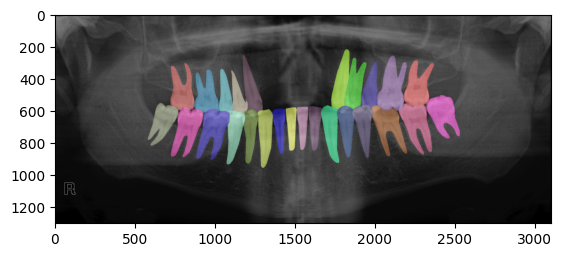

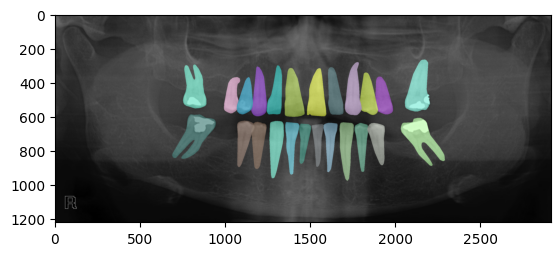

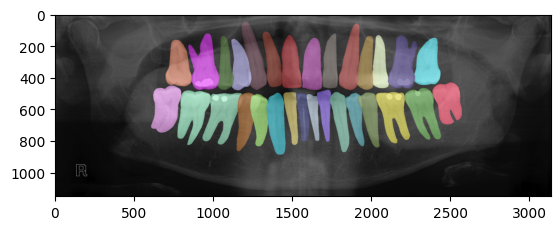

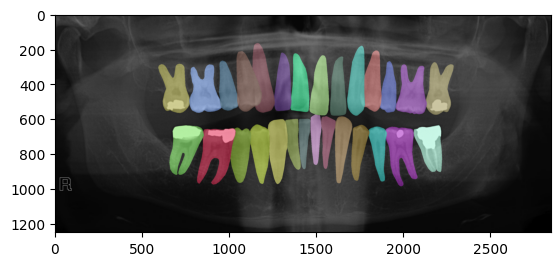

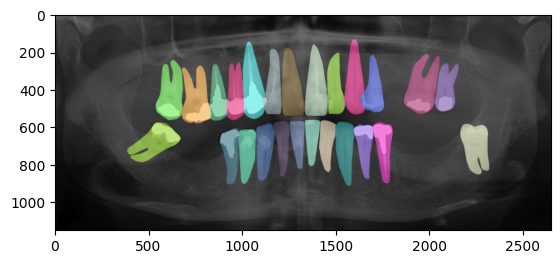

In [125]:
for json_file_path in json_file_paths[:5]:
    if not json_file_path.exists():
        break
    image_path = (image_root_path/json_file_path.stem).with_suffix(".jpg")
    segmentation = get_segmentation_polygon(json_file_path)
    
    image = cv2.imread(str(image_path))

# Create a zeros layer with the same size as the image
    layer = np.zeros_like(image)

    alpha = 0.5  # Define the alpha for blending

    for segment in segmentation:
        ctr = np.array(segment, dtype=np.int32)
        color = (randint(0, 255), randint(0, 255), randint(0, 255))

        # Fill the polygon in the layer
        cv2.fillPoly(layer, [ctr], color=color)

        # Blend the original image with the layer
        fake_image = cv2.addWeighted(image, alpha, layer, 1-alpha, 0)

    # Display the image
    plt.imshow(fake_image)
    plt.show()

    
    

In [69]:
for tooth_segment in segmentation:
    print(tooth_segment)

[2263.49  317.39]
[2263.74  311.21]
[2263.33  302.02]
[2262.36  294.44]
[2260.25  290.69]
[2257.28  289.03]
[2251.99  288.37]
[2245.38  289.7 ]
[2243.07  290.69]
[2236.46  296.96]
[2219.61  329.68]
[2207.71  370.98]
[2204.65  419.37]
[2202.03  434.67]
[2191.9   461.32]
[2177.64  495.22]
[2174.58  520.27]
[2177.43  532.79]
[2184.25  545.3 ]
[2197.91  560.95]
[2224.64  571.47]
[2255.08  572.61]
[2280.39  570.05]
[2294.9   565.78]
[2297.17  564.36]
[2317.37  557.25]
[2327.89  543.31]
[2334.43  523.97]
[2334.43  507.47]
[2323.34  459.41]
[2321.85  436.66]
[2321.88  418.49]
[2323.35  410.99]
[2332.92  388.31]
[2362.69  323.6 ]
[2363.43  314.18]
[2361.94  310.46]
[2359.96  307.98]
[2356.49  306.49]
[2353.52  306.49]
[2346.08  308.72]
[2342.12  311.7 ]
[2274.7  398.7]
[2270.49  400.93]
[2266.77  400.93]
[2261.32  396.46]
[2259.83  393.49]
[2258.09  385.81]
[2257.6   368.21]
[2259.92  347.81]
